# Import
For this to work, the data files need to be placed into the `data/raw` folder.

In [11]:
from pathlib import Path
import pandas as pd
import plotly_express as px

# # This is needed to have figures appear in external HTML file.
# from plotly.offline import init_notebook_mode
# init_notebook_mode()

In [12]:
SEP17_CSV = Path('../data/raw') / 'SEP2017.csv'
OCT17_CSV = Path('../data/raw') / 'OCT2017.csv'
NOV17_CSV = Path('../data/raw') / 'NOV2017.csv'
APR18_CSV = Path('../data/raw') / 'APR2018.csv'
MAY18_CSV = Path('../data/raw') / 'MAY2018.csv'

raw_sep_df = pd.read_csv(SEP17_CSV)
raw_oct_df = pd.read_csv(OCT17_CSV)
raw_nov_df = pd.read_csv(NOV17_CSV)
raw_apr_df = pd.read_csv(APR18_CSV)
raw_may_df = pd.read_csv(MAY18_CSV)

# Bring 'em all together into one dataframe.
raw_df = raw_sep_df.append(raw_oct_df).append(raw_nov_df).append(raw_apr_df).append(raw_may_df)

# Data

These csv files are joins of the `init_veh_stoph` and `trimet_stop_event` tables. Here's the query parameters.

* Routes 4, 10 and 14
* All stop types (service stops are 0 or 5)
* Stops 3637, 3641, 3633, 2642, 7856
    * 3637 - SE 11th and SE Madison [Just before the start of bus lane - actually begins at 10th]
    * 3641 - SE 7th and SE Madison 
    * 3633 - SE Grand and SE Madison [End of bus lane]
    * 2642 - Hawthorne Bridge, Westbound [Likely outside of this analysis]
    * 7856 - SE 7th and SE Clay [4 (or 2) bus only]
* Weekday service (code 'W')
* Between 5:00 am (18000) and 12:00 pm (43200)

# Goal

So the goal here is to see how long the busses take to traverse the bus lane. Let's use the full time window for now. (5:00 am (32400) until 12:00 pm (36000)).

As we learned before, lets start with route 14, from arrival at stop 3637 to arrival at 3633. We have ridership data too, but we'll look at that later.

## Columns
For now, let's limit the columns to the following:
* SERVICE_DATE   
* VEHICLE_NUMBER
* TRAIN
* ROUTE_NUMBER
* TRIP_NUMBER
* LEAVE_TIME
* STOP_TIME
* ARRIVE_TIME
* LOCATION_ID
* ESTIMATED_LOAD
* STOP_TYPE

In [39]:
cols = ['SERVICE_DATE', 'VEHICLE_NUMBER', 'TRAIN', 'ROUTE_NUMBER', 'TRIP_NUMBER', 'LEAVE_TIME', 'STOP_TIME', 'ARRIVE_TIME', 'LOCATION_ID', 'ESTIMATED_LOAD', 'STOP_TYPE']
filt_df = raw_df[cols][(raw_df['ROUTE_NUMBER'] == 14) & 
                       (raw_df['STOP_TIME'].between(18000 + 4 * 3600, 18000 + 5 * 3600)) &
                       (raw_df['LOCATION_ID'].isin([3637, 3633])) & 
                       (raw_df['STOP_TYPE'].isin([0, 5]))]
# Convert to datetime so they can be sorted
filt_df['SERVICE_DATE'] = pd.to_datetime(filt_df['SERVICE_DATE'], format='%d%b%Y:%H:%M:%S')
filt_df.sort_values('SERVICE_DATE', inplace=True)

In [40]:
def index_of_start_time(row):
    if (row['start_time'] >= 18000 + 0 * 3600) and (row['start_time'] <= 18000 + 1 * 3600): # 5am - 6am
        ind = None
    elif (row['start_time'] >= 18000 + 1 * 3600) and (row['start_time'] <= 18000 + 2 * 3600): # 6am - 7am
        ind = None
    elif (row['start_time'] >= 18000 + 2 * 3600) and (row['start_time'] <= 18000 + 3 * 3600): # 7am - 8am
        ind = None
    elif (row['start_time'] >= 18000 + 3 * 3600) and (row['start_time'] <= 18000 + 4 * 3600): # 8am - 9am
        ind = None
    elif (row['start_time'] >= 18000 + 4 * 3600) and (row['start_time'] <= 18000 + 4.5 * 3600): # 9am - 9:30am
        ind = 1
    elif (row['start_time'] >= 18000 + 4.5 * 3600) and (row['start_time'] <= 18000 + 5 * 3600): # 9:30am - 10:00am
        ind = 2
    elif (row['start_time'] >= 18000 + 5 * 3600) and (row['start_time'] <= 18000 + 6 * 3600): # 10am - 11am
        ind = None
    elif (row['start_time'] >= 18000 + 6 * 3600) and (row['start_time'] <= 18000 + 7 * 3600): # 11am - 12am
        ind = None
    else:
        ind = None
    return ind

In [41]:
# To filter this all down, let's first group by date, then trip number within date. Note it appears trip number is unique while train number is not.
grouped = filt_df.groupby(['SERVICE_DATE', 'TRIP_NUMBER'])

# How we'll make the output (to convert to DataFrame)
bus_trips = {'date': [], 'trip': [], 'is_complete_trip': [], 'start_time': [], 'end_time': []}

for name, group in grouped:
    # If a group doesn't have 2 entries, then we can't calculate and elapsed time. We'll flag them for now and deal with them later.
    if group.shape[0] != 2:
        bus_trips['is_complete_trip'].append(False)
    else:
        bus_trips['is_complete_trip'].append(True)
    bus_trips['date'].append(name[0])
    bus_trips['trip'].append(name[1])
    try:
        bus_trips['start_time'].append(group[group['LOCATION_ID'] == 3637]['LEAVE_TIME'].values[0])
    except IndexError:
        bus_trips['start_time'].append(None)
    
    try: 
        bus_trips['end_time'].append(group[group['LOCATION_ID'] == 3633]['ARRIVE_TIME'].values[0])
    except IndexError:
        bus_trips['end_time'].append(None)
    
trips_df = pd.DataFrame(bus_trips)
trips_df['elapsed_time'] = trips_df['end_time'] - trips_df['start_time']
trips_df['start_ind'] = trips_df.apply(lambda row: index_of_start_time(row), axis=1)

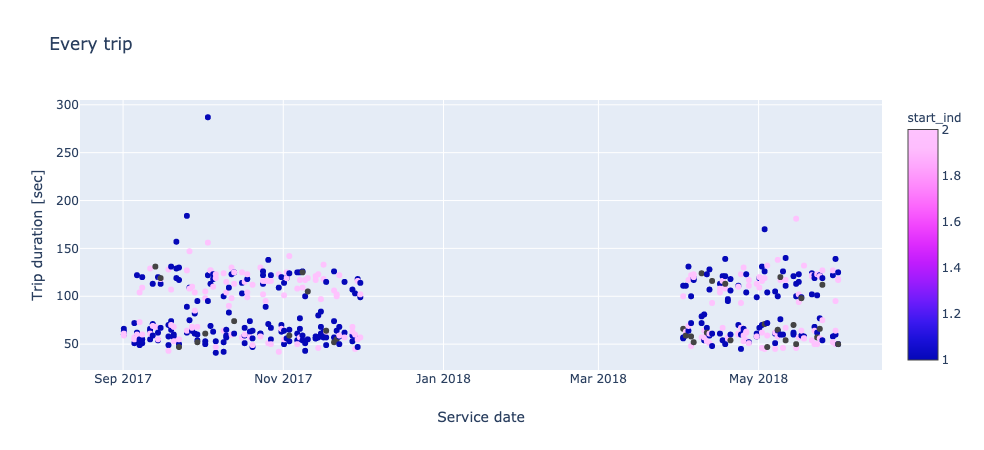

In [42]:
px.scatter(trips_df[trips_df['is_complete_trip']], x='date', y='elapsed_time', labels={'date': 'Service date', 'elapsed_time': 'Trip duration [sec]'},
#            range_x=[pd.to_datetime('01SEP2017', format='%d%b%Y'), pd.to_datetime('01DEC2017', format='%d%b%Y')], 
           color='start_ind', title='Every trip')

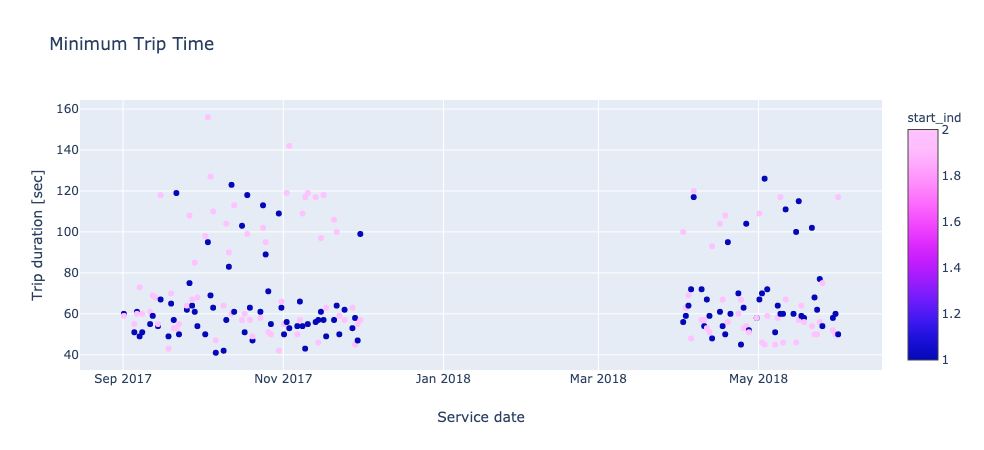

In [45]:
day_minimums = {'date': [], 'start_ind': [], 'elapsed_time': []}
for name, group in trips_df.groupby(['date', 'start_ind']):
    day_minimums['date'].append(name[0])
    day_minimums['start_ind'].append(name[1])
    day_minimums['elapsed_time'].append(group.min()['elapsed_time'])
min_df = pd.DataFrame(day_minimums)

px.scatter(min_df, x='date', y='elapsed_time', labels={'date': 'Service date', 'elapsed_time': 'Trip duration [sec]'},
#            range_x=[pd.to_datetime('01SEP2017', format='%d%b%Y'), pd.to_datetime('01DEC2017', format='%d%b%Y')],
           title='Minimum Trip Time', color='start_ind')

0 - 8am to 9am
1 - 9 to 930
2 - 930 to 10
3 - 10 to 11

In [23]:
trips_df

,date,trip,is_complete_trip,start_time,end_time,elapsed_time,start_ind
0,2017-09-01,1130,False,28915.0,NaN,NaN,0.0
1,2017-09-01,1140,True,29501.0,29624.0,123.0,0.0
2,2017-09-01,1150,True,29769.0,29842.0,73.0,0.0
3,2017-09-01,1160,True,30327.0,30419.0,92.0,0.0
4,2017-09-01,1170,False,NaN,30478.0,NaN,NaN
5,2017-09-01,1180,True,30812.0,30959.0,147.0,0.0
6,2017-09-01,1190,True,31378.0,31525.0,147.0,0.0
7,2017-09-01,1200,True,31922.0,32038.0,116.0,0.0
8,2017-09-01,1210,True,32223.0,32306.0,83.0,0.0
9,2017-09-01,1220,True,32709.0,32788.0,79.0,1.0
